In [19]:
import pandas as pd
import tensorflow as tf
import numpy as np
import os as os
import matplotlib.pyplot as plt

# own code base
import sys
sys.path.append("..")
import tf_loss_functions as lf
import splines as sp

In [20]:
basis_dimension = 20
degree_bsplines = 3
penalty_diff_order = 2


zambia = pd.read_table('Data/zambia_height92.txt')

c_breastf_d = zambia.loc[:, 'c_breastf']
c_age_d = zambia.loc[:, "c_age"]
labels = zambia.loc[:, 'zscore']
labels_expanded = np.expand_dims(labels, 1)

# create splines from class
age = sp.pspline(x=c_age_d, degree_bsplines=degree_bsplines, penalty_diff_order=penalty_diff_order, knot_type="equi", basis_dimension=basis_dimension)
breastf = sp.pspline(x=c_breastf_d, degree_bsplines=degree_bsplines, penalty_diff_order=penalty_diff_order, knot_type="equi", basis_dimension=basis_dimension)

In [21]:
labels.shape

(4421,)

In [22]:
results_gcv = pd.read_csv("Results/Smoothing_param_zambia_method=gcv_2d_epochs=5000.csv", index_col=0).iloc[:-1]
epochs = results_gcv.iloc[:,0]
lambda_param_x1_values = results_gcv.iloc[:,1]
lambda_param_x2_values = results_gcv.iloc[:,2]
gcv_values = results_gcv.iloc[:,3]


In [23]:
results_spline = np.load(file = "Results/final_spline_zambia_method=gcv_2d_epoch=5000.npz")

weights_x1 = results_spline["weights_x1"]
weights_x2 = results_spline["weights_x2"]
lambda_param_x1_opt = results_spline["reg_param_x1"]
lambda_param_x2_opt = results_spline["reg_param_x2"]

gcv_opt = lf.gcv_2d(y = labels_expanded, 
            design_matrix_Z_1 = age.design_matrix_d, 
            reg_matrix_K_1 = age.penalty_matrix_d, 
            reg_param_1 = lambda_param_x1_opt,
            design_matrix_Z_2 = breastf.design_matrix_d, 
            reg_matrix_K_2 = breastf.penalty_matrix_d, 
            reg_param_2 = lambda_param_x2_opt,
            )

In [24]:
print("Optimal lambda parameter for age: ", lambda_param_x1_opt)
print("Optimal lambda parameter for breast feeding: ", lambda_param_x2_opt)

Optimal lambda parameter for age:  4495.3296
Optimal lambda parameter for breast feeding:  49486.676


## - Spline Plot

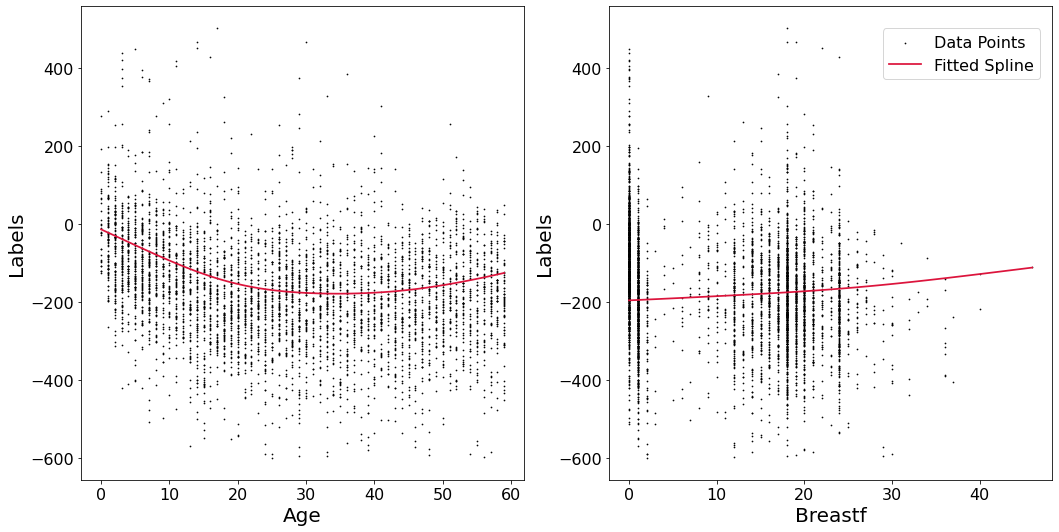

In [25]:
font_size = 20
font_size_legend = 16
font_size_ticks = 16
font_size_small = 18

x1_plot = np.linspace(c_age_d.min(), c_age_d.max(),num=100)
x2_plot = np.linspace(c_breastf_d.min(), c_breastf_d.max(),num=100)

fig, axs = plt.subplots(1, 2, figsize=(15, 7.5))

axs[0].scatter(c_age_d, labels, marker='o', s=0.5, c="black", label="data points")

matrix_plot = sp.build_base(x1_plot, degree = degree_bsplines, knot_type = "given", given_knots = age.knots)[0]
y_hat = np.dot(matrix_plot, weights_x1)
axs[0].plot(x1_plot, y_hat+y_hat.mean(), lw=1.75, label=f"Final Result", color="crimson")

axs[0].set_xlabel("Age", fontsize=font_size)
axs[0].set_ylabel('Labels', fontsize=font_size)
axs[0].tick_params(labelsize=font_size_ticks)


axs[1].scatter(c_breastf_d, labels, marker='o', s=0.5, c="black", label="Data Points")

matrix_plot = sp.build_base(x2_plot, degree = degree_bsplines, knot_type = "given", given_knots = breastf.knots)[0]
y_hat = np.dot(matrix_plot, weights_x2)
axs[1].plot(x2_plot, y_hat+y_hat.mean(), lw=1.75, label=f"Fitted Spline", color="crimson")

axs[1].set_xlabel("Breastf", fontsize=font_size)
axs[1].set_ylabel('Labels', fontsize=font_size)
axs[1].tick_params(labelsize=font_size_ticks)
axs[1].legend(loc='center left', bbox_to_anchor=(0.6, 0.9), fontsize=font_size_legend)

fig.set_facecolor('white')
fig.tight_layout()
plt.savefig(f"Plots/multidim_zambia_spline.png", bbox_inches='tight', dpi=300)
plt.savefig(f"Plots/multidim_zambia_spline.pdf", bbox_inches='tight', dpi=300)
plt.show()

## - Optimization Plots

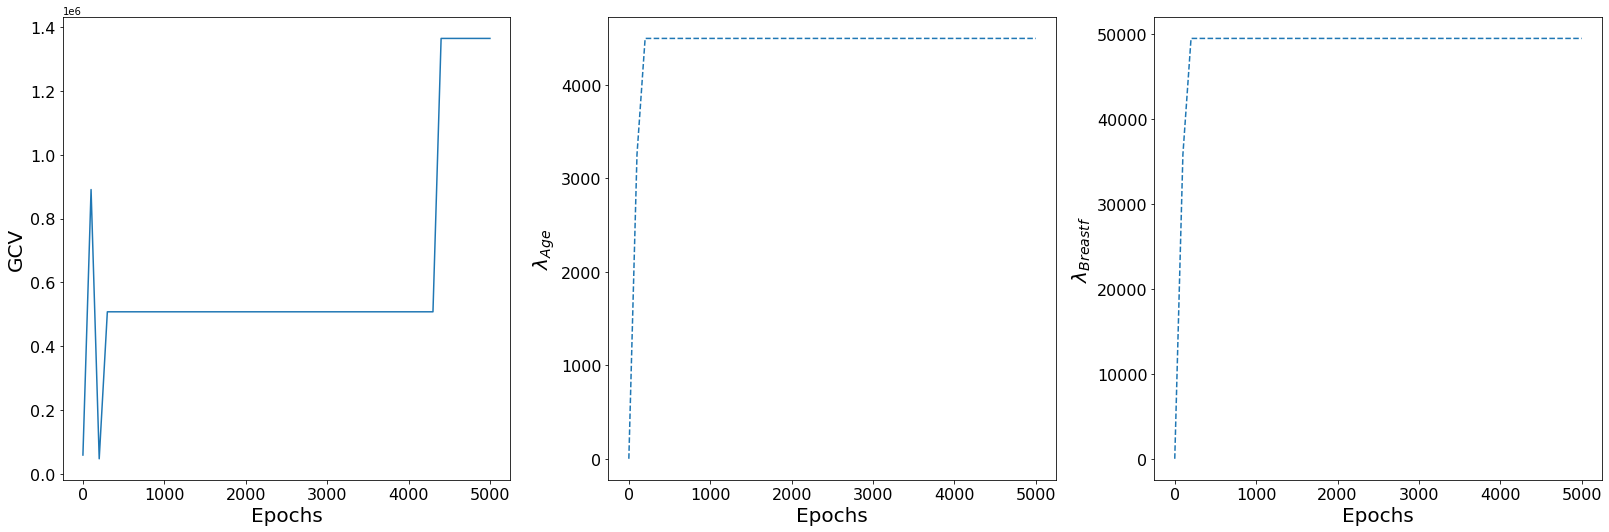

In [26]:
fig, axs = plt.subplots(1,3,figsize=(22.5, 7.5))

axs[0].plot(epochs, gcv_values)
axs[0].set_xlabel('Epochs', fontsize=font_size)
axs[0].set_ylabel('GCV', fontsize=font_size)
axs[0].tick_params(labelsize=font_size_ticks)

axs[1].plot(epochs, lambda_param_x1_values, ls="--")
axs[1].set_xlabel('Epochs', fontsize=font_size)
axs[1].set_ylabel(r"$\lambda_{Age}$", fontsize=font_size)
axs[1].tick_params(labelsize=font_size_ticks)

axs[2].plot(epochs, lambda_param_x2_values, ls="--")
axs[2].set_xlabel('Epochs', fontsize=font_size)
axs[2].set_ylabel(r"$\lambda_{Breastf}$", fontsize=font_size)
axs[2].tick_params(labelsize=font_size_ticks)

fig.set_facecolor('white')
fig.tight_layout()
plt.savefig("Plots/multidim_zambia_optimization.png", bbox_inches="tight", dpi=300)
plt.savefig("Plots/multidim_zambia_optimization.pdf", bbox_inches="tight", dpi=300)
plt.show()

### - Contour plot

In [27]:
lambda_param_x1_plot = np.sort(lambda_param_x1_values)
lambda_param_x2_plot = np.sort(lambda_param_x2_values)
n = lambda_param_x1_plot.shape[0]
print(n)
gcv_plot_values = np.empty([n, n])

for i in range(n):
    for j in range(n):
        gcv = lf.gcv_2d(
            y = labels_expanded, 
            design_matrix_Z_1 = age.design_matrix_d, 
            reg_matrix_K_1 = age.penalty_matrix_d, 
            reg_param_1 = lambda_param_x1_plot[i],
            design_matrix_Z_2 = breastf.design_matrix_d, 
            reg_matrix_K_2 = breastf.penalty_matrix_d, 
            reg_param_2 = lambda_param_x2_plot[j],
            )
        gcv_plot_values[i,j] = gcv

51


In [31]:
print(lambda_param_x2_values.min(), lambda_param_x2_values.max())

5.0 49486.67578125


(51, 51)
35422.0625 6177498.0


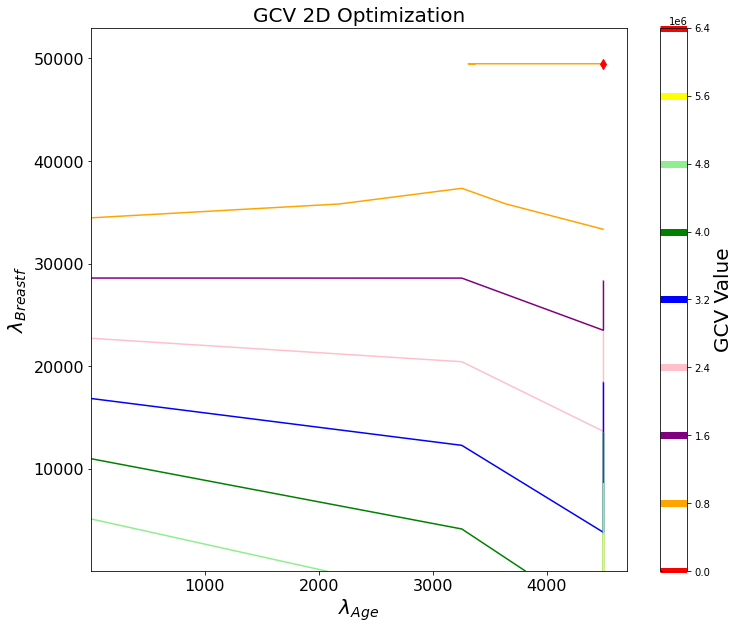

In [32]:

X, Y = np.meshgrid(np.array(lambda_param_x1_plot), np.array(lambda_param_x2_plot))
Z = np.array(gcv_plot_values)
print(Z.shape)

print(Z.min(), Z.max())
levels = np.array([36000,50000,100000,500000,1000000])


fig, ax = plt.subplots(1,1,figsize=(12, 10))
CS = ax.contour(X, Y, Z, levels=7, colors=["red", "orange", "purple", "pink", "blue", "green", "lightgreen", "yellow"])
ax.scatter(lambda_param_x1_opt, lambda_param_x2_opt, marker="d", c="red", s=50, zorder=10, label="Min GCV")
ax.set_xlim([lambda_param_x1_values.min(), 4700])
ax.set_ylim([lambda_param_x2_values.min(), 53000])
ax.set_xlabel(r'$\lambda_{Age}$', fontsize=font_size)
ax.set_ylabel(r'$\lambda_{Breastf}$', fontsize=font_size)
ax.set_title('GCV 2D Optimization', fontsize=font_size)
ax.tick_params(labelsize=font_size_ticks)

cbar = plt.colorbar(CS)
cbar.set_label('GCV Value', fontsize=font_size)
for c in cbar.ax.collections:
    c.set_linewidth(7)  

fig.set_facecolor('white')
# plt.legend(fontsize=font_size_legend)
plt.savefig("Plots/multidim_zambia_contour_plot.png", bbox_inches="tight")
plt.savefig("Plots/multidim_zambia_contour_plot.pdf", bbox_inches="tight")
plt.show()

### - Countour plot around optimum

In [33]:
lambda_param_x1_range = np.arange(np.round(lambda_param_x1_opt-100, 0), np.round(lambda_param_x1_opt+100, 0), 1)
lambda_param_x2_range = np.arange(np.round(lambda_param_x2_opt-100, 0), np.round(lambda_param_x2_opt+100, 0), 1)

n = lambda_param_x1_range.shape[0]
print(n)

gcv_range_values = np.empty([n,n])
for i in range(n):
    for j in range(n):
        gcv = lf.gcv_2d(
            y = labels_expanded, 
            design_matrix_Z_1 = age.design_matrix_d, 
            reg_matrix_K_1 = age.penalty_matrix_d, 
            reg_param_1 = lambda_param_x1_range[i],
            design_matrix_Z_2 = breastf.design_matrix_d, 
            reg_matrix_K_2 = breastf.penalty_matrix_d, 
            reg_param_2 = lambda_param_x2_range[j],
            )
        gcv_range_values[i,j] = gcv

200


(200, 200)
21739.744140625 9.2836054828476e+17


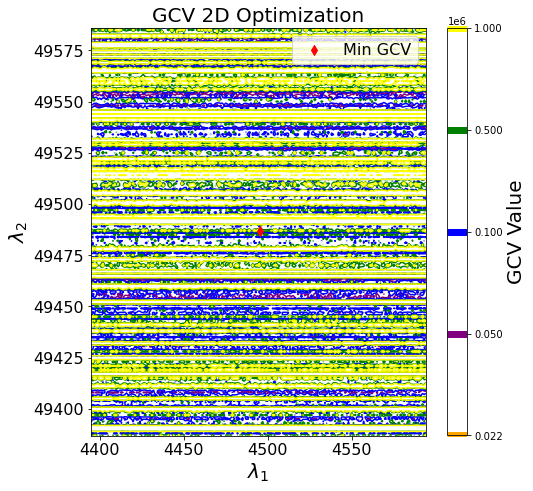

In [34]:
X, Y = np.meshgrid(lambda_param_x1_range, lambda_param_x2_range)
Z = np.array(gcv_range_values)
print(Z.shape)


print(Z.min(), Z.max())

levels = np.array([22000,50000,100000, 500000, 1000000])

fig, ax = plt.subplots(1,1,figsize=(7.5, 7.5))
CS = ax.contour(X, Y, Z, levels=levels, colors=["orange", "purple", "blue", "green", "yellow"])
ax.scatter(lambda_param_x1_opt, lambda_param_x2_opt, marker="d", c="red", s=50, zorder=10, label='Min GCV')
ax.set_xlabel(r'$\lambda_1$', fontsize=font_size)
ax.set_ylabel(r'$\lambda_2$', fontsize=font_size)
ax.set_title('GCV 2D Optimization', fontsize=font_size)
ax.tick_params(labelsize=font_size_ticks)

cbar = plt.colorbar(CS)
cbar.set_label('GCV Value', fontsize=font_size)
for c in cbar.ax.collections:
    c.set_linewidth(7)  

fig.set_facecolor('white')
plt.legend(fontsize=font_size_legend)
plt.savefig("Plots/multidim_zambia_contour_plot_opt.png", bbox_inches="tight", dpi=300)
plt.savefig("Plots/multidim_zambia_contour_plot_opt.pdf", bbox_inches="tight", dpi=300)
plt.show()

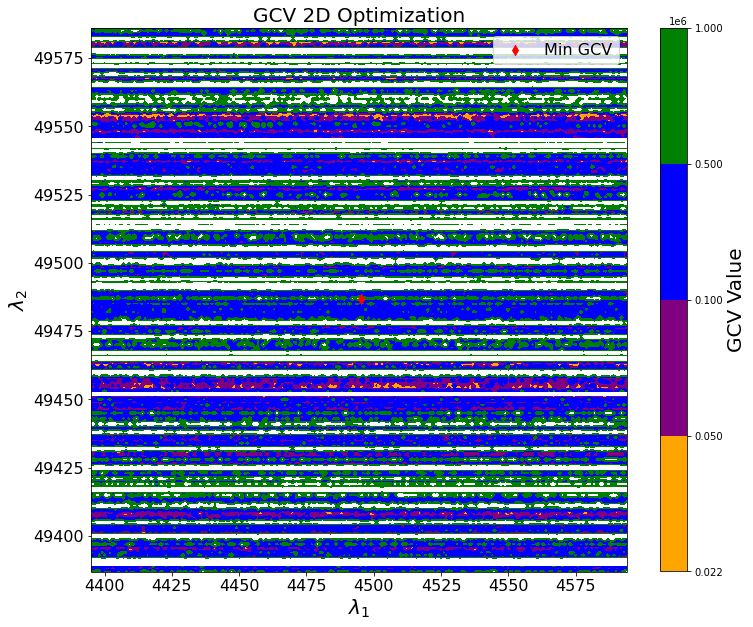

In [35]:

fig, ax = plt.subplots(figsize=(12, 10))
contour = ax.contourf(X, Y, Z, levels=levels, colors=["orange", "purple", "blue", "green", "yellow"])
cbar = plt.colorbar(contour)
cbar.set_label('GCV Value', fontsize=font_size)

ax.scatter(lambda_param_x1_opt, lambda_param_x2_opt, marker="d", c="red", s=50, zorder=10, label='Min GCV')

ax.set_xlabel(r'$\lambda_1$', fontsize=font_size)
ax.set_ylabel(r'$\lambda_2$', fontsize=font_size)
ax.set_title('GCV 2D Optimization', fontsize=font_size)
ax.set_xlim(min(lambda_param_x1_range), max(lambda_param_x1_range))
ax.set_ylim(min(lambda_param_x2_range), max(lambda_param_x2_range))
ax.tick_params(labelsize=font_size_ticks)


fig.set_facecolor('white')
plt.legend(fontsize=font_size_legend)
plt.savefig("Plots/multidim_zambia_contourf_plot_opt.png", bbox_inches="tight", dpi=300)
plt.savefig("Plots/multidim_zambia_contourf_plot_opt.pdf", bbox_inches="tight", dpi=300)
plt.show()

(51, 51)


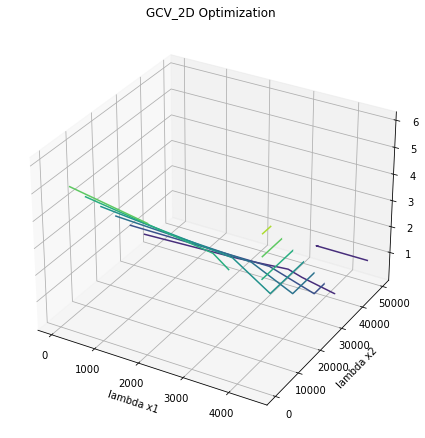

In [36]:
X, Y = np.meshgrid(np.array(lambda_param_x1_plot), np.array(lambda_param_x2_plot))
Z = np.array(gcv_plot_values)
print(Z.shape)

fig = plt.figure(figsize=(7.5,7.5))
ax = fig.add_subplot(111, projection='3d')
CS = ax.contour(X, Y, Z)
ax.clabel(CS, inline=True, fontsize=10)
ax.set_xlabel('lambda x1')
ax.set_ylabel('lambda x2')
ax.set_title('GCV_2D Optimization')
fig.set_facecolor('white')
# fig.tight_layout()
# plt.savefig("multidim_zambia_3d_contour_plot.png", bbox_inches="tight")
plt.show()

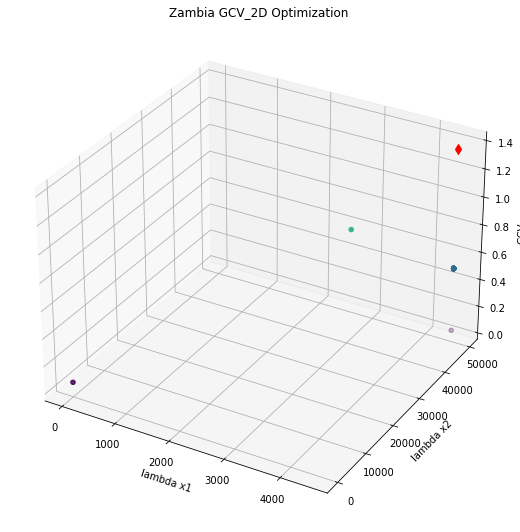

In [37]:
# Create 3D scatter plot
fig = plt.figure(figsize=(7.5,7.5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(lambda_param_x1_values, lambda_param_x2_values, gcv_values, c=gcv_values, cmap='viridis')
ax.scatter3D(lambda_param_x1_opt, lambda_param_x2_opt, gcv_opt, marker="d", c="red", s=50)

# Set labels and title
ax.set_xlabel('lambda x1')
ax.set_ylabel('lambda x2')
ax.set_zlabel('GCV')
ax.zaxis.label.set_rotation(90)
ax.set_title('Zambia GCV_2D Optimization')

# Show the plot
fig.set_facecolor('white')
plt.tight_layout()
# plt.savefig("Plots/multidim_zambia_3d_scatter.png", bbox_inches="tight")
plt.show()

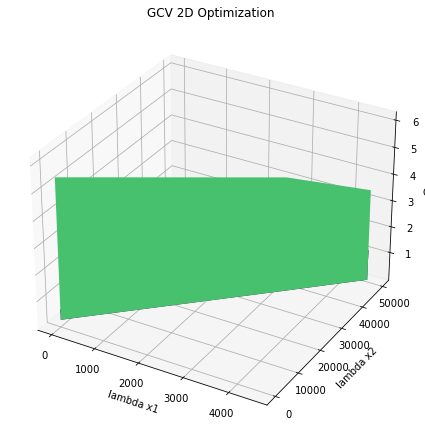

In [38]:
fig = plt.figure(figsize=(7.5,7.5))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(np.array(lambda_param_x1_values), np.array(lambda_param_x2_values), np.array(gcv_plot_values), cmap='viridis')

# Optionally, you can add labels to the axes and a title
ax.set_xlabel('lambda x1')
ax.set_ylabel('lambda x2')
ax.set_zlabel('GCV')
ax.set_title('GCV 2D Optimization')

fig.set_facecolor('white')
# plt.savefig("multidim_zambia_surface_plot.png", bbox_inches="tight")
plt.show()